<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter2/EEG%20Signals.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.datasets import fetch_openml

In [2]:
from sklearn.datasets import fetch_openml

eeg = fetch_openml(data_id=1471, as_frame=True)
# https://www.openml.org/d/1471
# the whole measurement spans 117 seconds

c:\Users\ulyss\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
increment = 117 / len(eeg['data'])
fs = len(eeg['data']) // 117

In [4]:
len(eeg['data'])

14980

In [5]:
import numpy as np
index = np.linspace(
    start=0,
    stop=increment*len(eeg['data']),
    num=len(eeg['data'])
)

ts_index = pd.to_datetime(index, unit='s')
v1 = pd.Series(name='V1', data=eeg['data']['V1'].values, index=ts_index)

In [6]:
slicing = (v1.index >= '1970-01-01 00:00:08') & (v1.index <='1970-01-01 00:01:10.000000000')
v1[slicing]

1970-01-01 00:00:08.006208692    4289.74
1970-01-01 00:00:08.014019627    4284.10
1970-01-01 00:00:08.021830562    4280.00
1970-01-01 00:00:08.029641498    4289.74
1970-01-01 00:00:08.037452433    4298.46
                                  ...   
1970-01-01 00:01:09.962547566    4289.74
1970-01-01 00:01:09.970358501    4283.08
1970-01-01 00:01:09.978169437    4284.62
1970-01-01 00:01:09.985980372    4289.23
1970-01-01 00:01:09.993791307    4290.77
Name: V1, Length: 7937, dtype: float64

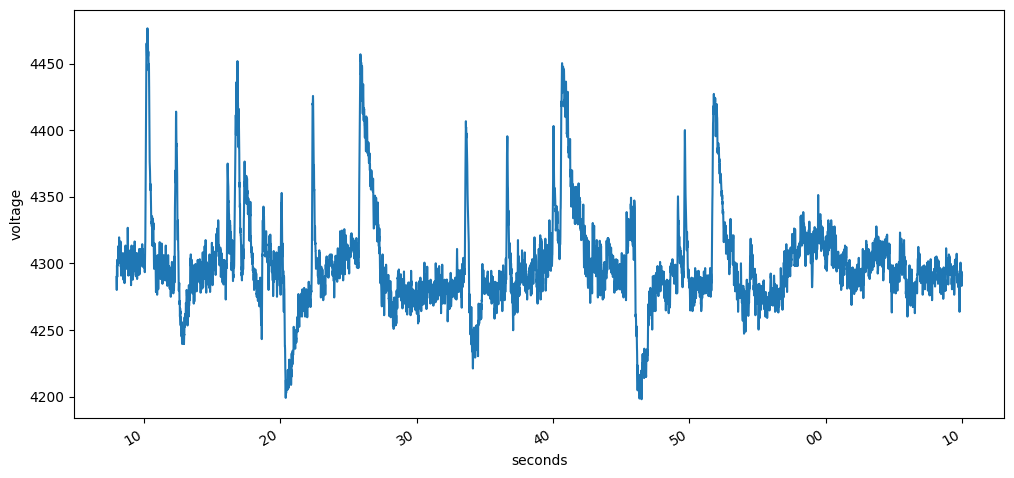

In [7]:
date_formatter = DateFormatter("%S")
ax = v1[slicing].plot(figsize=(12, 6))
ax.xaxis.set_major_formatter(date_formatter)
plt.ylabel('voltage')
plt.xlabel('seconds');

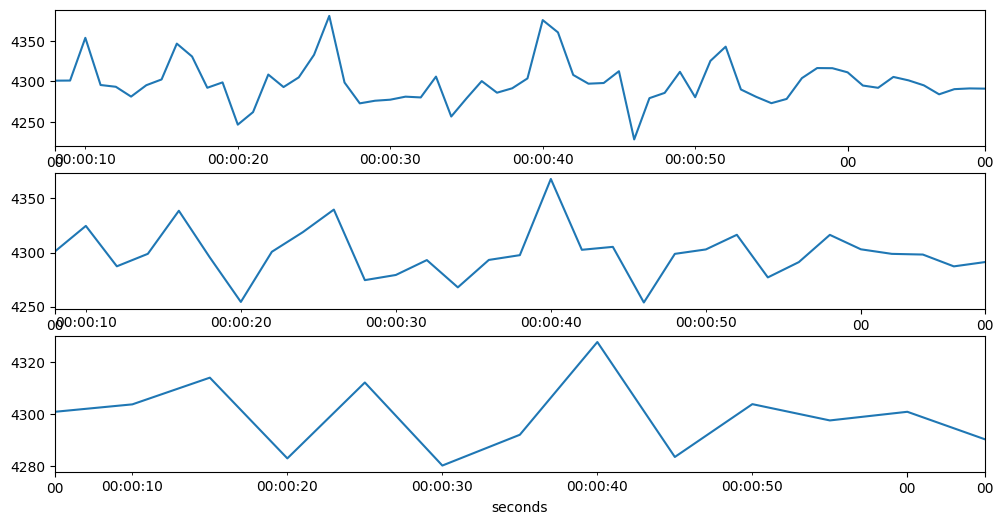

In [8]:
plt.subplot(311)
ax1 = v1[slicing].resample('1s').mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(312)
ax1 = v1[slicing].resample('2s').mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(313)
ax2 = v1[slicing].resample('5s').mean().plot(figsize=(12, 6))
ax2.xaxis.set_major_formatter(date_formatter)
plt.xlabel('seconds');

In [9]:
from scipy import signal
f, Pxx_den = signal.welch(
    v1[slicing].values,
    fs,
    nperseg=4000,
    scaling='spectrum'
)

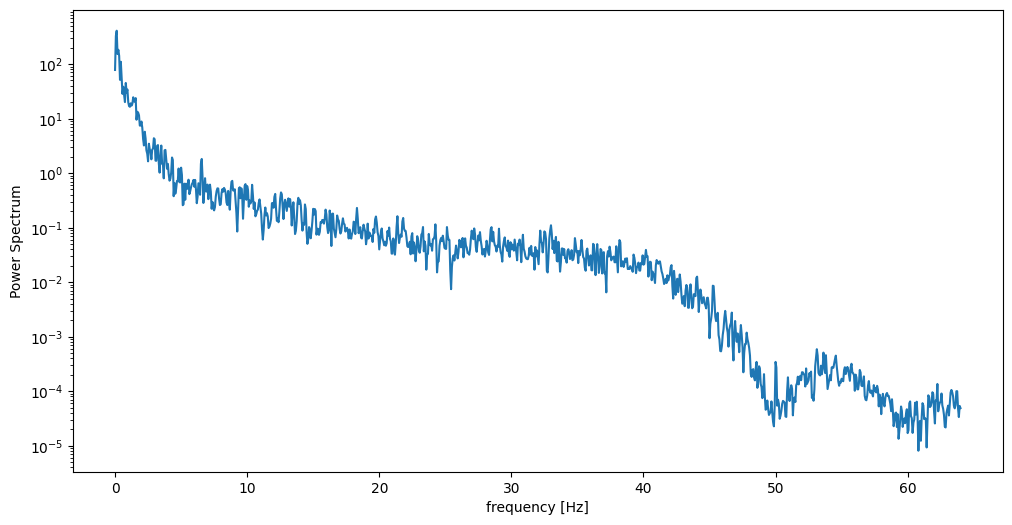

In [10]:
from scipy import signal
f, Pxx_den = signal.welch(
    v1[slicing].values,
    fs,
    nperseg=2048,
    scaling='spectrum'
)
plt.figure(figsize=(12, 6))
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectrum');

In [14]:
# https://datahub.io/core/global-temp

import pandas as pd
temperatures = pd.read_csv('monthly_csv.csv')
temperatures['Date'] = pd.to_datetime(temperatures['Date'])
temperatures = temperatures.pivot_table(index='Date', columns='Source', values='Mean')


In [15]:
temperatures['GCAG'].index.month

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype='int32', name='Date', length=1644)

c:\Users\ulyss\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ulyss\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ulyss\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ulyss\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

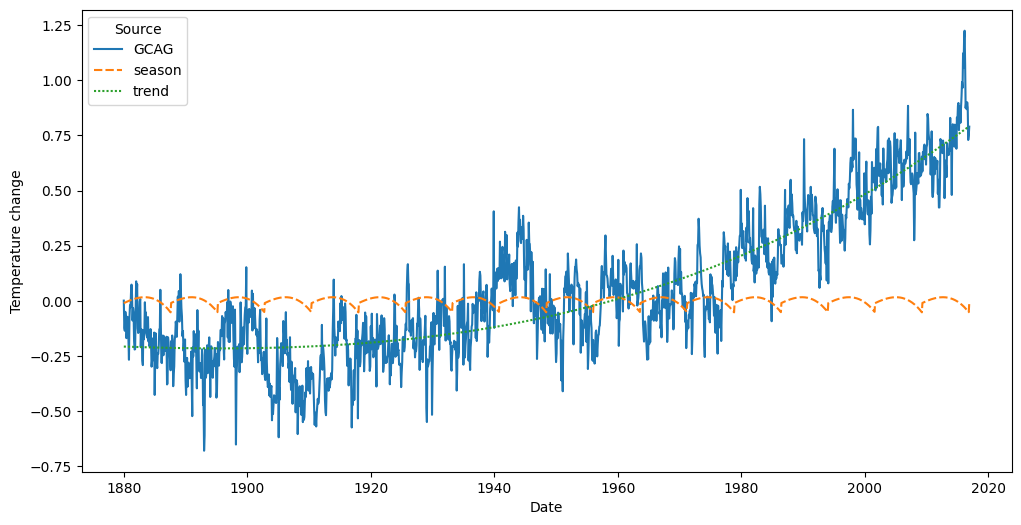

In [16]:
from numpy import polyfit

# fit polynomial: E = \sum_{j=0}^k |p(x_j) - y_j|^2

def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)

def get_season(s, yearly_periods=4, degree=3):
    X = [i%(365/yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)

def get_trend(s, degree=3):
    X = list(range(len(s)))  # (s.index.year - s.index.year.min()).values
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)


import seaborn as sns

plt.figure(figsize=(12, 6))
temperatures['trend'] = get_trend(temperatures['GCAG'])
temperatures['season'] = get_season(temperatures['GCAG'] - temperatures['trend'])
sns.lineplot(data=temperatures[['GCAG', 'season', 'trend']])
plt.ylabel('Temperature change');

In [17]:
temperatures.head()

Source,GCAG,GISTEMP,trend,season
Date,,,,
1880-01-06,0.0009,-0.30,-0.207448,-0.010461
1880-02-06,-0.1229,-0.21,-0.207531,-0.009336
1880-03-06,-0.1357,-0.18,-0.207613,-0.008226
1880-04-06,-0.0499,-0.27,-0.207695,-0.007131
1880-05-06,-0.0738,-0.14,-0.207777,-0.006051
